In [1]:
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import bayes_mvs as bayesest 
import time

sys.path.insert(0, '../../../../PyEcoLib')
from PopSimulator import PopSimulator
from simulator import Simulator
%matplotlib inline

In [43]:
meanbirthsize = 1 # micron 
doubling_time = 18 #min 
tmax = 7*doubling_time #min 
sample_time = 0.1*doubling_time #min 
div_steps = 10
ncells = 200

In [44]:
gr = np.log(2)/doubling_time 

In [45]:
if not os.path.exists('./data'):
    os.makedirs('./data') #data path
if not os.path.exists('./figures'):
    os.makedirs('./figures') #Figures path

In [46]:
v0=meanbirthsize*np.ones(ncells)
sim = PopSimulator(ncells=ncells,gr = gr, sb=meanbirthsize, steps = div_steps,nu=2,V0array=v0) #Initializing the simulator

In [47]:
start = time.time()
sim.szdyn(tmax = tmax, sample_time = 0.1*doubling_time, FileName=  "./data/data2Pop.csv", DivEventsFile="./data/DivEvents2.csv")
print('It took', np.int(time.time()-start), 'seconds.')

It took 6884 seconds.


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


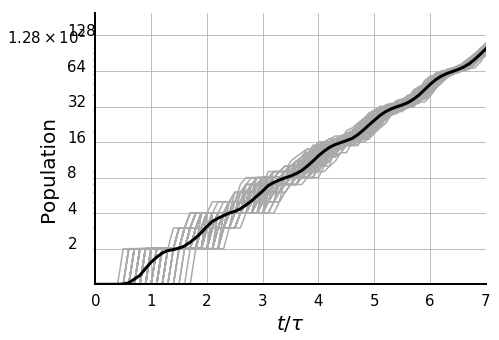

In [48]:
data1=pd.read_csv("./data/data2Pop.csv")
fig, ax = plt.subplots(1,1, figsize=(7,5))
smparr=data1.Sample.unique()
smparr.sort()
for smp in smparr:
    df=data1[data1.Sample==smp]
    tm,N=np.unique(df['Time'],return_counts=True)
    plt.plot(tm/doubling_time,N,c="#AAAAAA")
tm,N=np.unique(data1['Time'],return_counts=True)
plt.plot(tm/doubling_time,N/ncells,lw=3,c='k')
plt.yscale('log')
#plt.ylabel("$Population$",size=20)
plt.xlabel(r"$t/\tau$",size=20)
plt.xlabel(r"$t/\tau$",size=20)
plt.ylim([0,200])
plt.xlim([0,tmax/doubling_time])
taqui=np.arange(0,(tmax+1)/doubling_time,step=1)
plt.xticks(np.array(taqui))
taqui=2**np.arange(1,8,step=1)
plt.yticks(np.array(taqui))
plt.grid()
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
for l in range(len(taqui)):
    plt.text(-.5,taqui[l],str(taqui[l]),fontsize=15)
plt.text(-1,20,'Population',fontsize=20,rotation=90)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
    ax.tick_params(axis='both', width=2,length=6)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
    ax.tick_params(axis='both', width=0,length=6)
plt.savefig('./figures/Population.eps',bbox_inches='tight')
plt.savefig('./figures/Population.svg',bbox_inches='tight')

In [49]:
import random
def bootstrap(arr):
    mnar=np.empty(1000)
    for l in range(1000):
        mn=np.mean(random.choices(arr,k=len(arr)))
        mnar[l]=mn
    mn=np.mean(mnar)
    up=np.quantile(mnar,0.95)
    down=np.quantile(mnar,0.05)
    return(mn,0.5*(-down+up))

In [50]:
import random
def bootstrapCV2(arr):
    mnar=np.empty(1000)
    for l in range(1000):
        v=random.choices(arr,k=len(arr))
        mn=np.var(v)/np.mean(v)**2
        mnar[l]=mn
    mn=np.mean(mnar)
    up=np.quantile(mnar,0.95)
    down=np.quantile(mnar,0.05)
    return(mn,0.5*(-down+up))

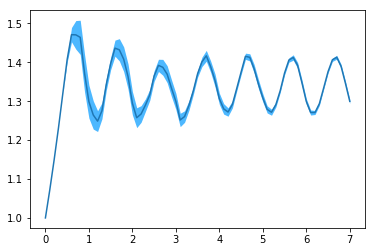

In [51]:
data1=pd.read_csv("./data/data2Pop.csv")

timearray1=data1.Time.unique()

mnszarray=[]
cvszarray=[]
errcv2sz=[]
errmnsz=[]

for t in timearray1:
    df=data1[data1.Time==t]
    szs=df.Size.values.tolist()
    mnszarray.append(bootstrap(szs)[0])
    errmnsz.append(bootstrap(szs)[1])
    cvszarray.append(bootstrapCV2(szs)[0])
    errcv2sz.append(bootstrapCV2(szs)[1])
plt.plot(timearray1/doubling_time,mnszarray)
plt.fill_between(np.array(timearray1)/doubling_time,np.array(mnszarray)-np.array(errmnsz),np.array(mnszarray)+np.array(errmnsz),
                 alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0,label="SSA")

timearray2=data1.Time.unique()

mnsz2array=[]
cvszarray2=[]
errcv2sz2arr=[]
errmnsz2arr=[]

for t in timearray2:
    df=data1[data1.Time==t]
    mntemp=[]
    vartemp=[]
    meanerrmn=[]
    meanerrvar=[]
    smparray=df.Sample.unique()
    for s in smparray:
        dft=df[df.Sample==s]
        if len(dft)>1:
            conc=dft.Size.tolist()
            mntemp.append(np.mean(conc))
            vartemp.append(np.var(conc)/np.mean(conc)**2)

        else:
            conc=dft.Size
            mntemp.append(conc.tolist()[0])
            vartemp.append(0)
            meanerrmn.append(0)
            meanerrvar.append(0)
        
    mnsz2array.append(bootstrap(mntemp)[0])
    errmnsz2arr.append(bootstrap(mntemp)[1])
    cvszarray2.append(bootstrap(vartemp)[0])
    errcv2sz2arr.append(bootstrap(vartemp)[1])

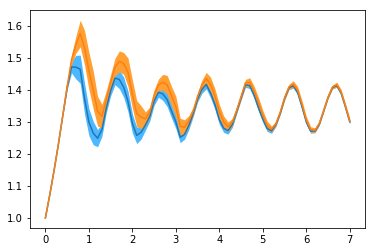

In [52]:
plt.plot(timearray2/doubling_time,mnszarray)
plt.fill_between(np.array(timearray1)/doubling_time,np.array(mnszarray)-np.array(errmnsz),np.array(mnszarray)+np.array(errmnsz),
                 alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0,label="SSA")
    
plt.plot(timearray2/doubling_time,mnsz2array)
plt.fill_between(np.array(timearray2)/doubling_time,np.array(mnsz2array)-np.array(errmnsz2arr),np.array(mnsz2array)+np.array(errmnsz2arr),
               alpha=1, edgecolor='#FFA035', facecolor='#FFA035',linewidth=0,label="SSA")

In [12]:
meanbirthsize = 1 # micron
doubling_time = 18 #min
tmax = 7*doubling_time #min
sample_time = 2 #min
div_steps = 10
ncells = 2000

In [13]:
v0=meanbirthsize*np.ones(ncells)
sim = PopSimulator(ncells=ncells,gr = gr, sb=meanbirthsize, steps = div_steps,nu=1,V0array=v0) #Initializing the simulator

In [14]:
start = time.time()
sim.szdyn(tmax = tmax, sample_time = 0.1*doubling_time, FileName=  "./data/dataPopMM.csv", DivEventsFile="./data/DivEventsMM.csv")
print('It took', np.int(time.time()-start), 'seconds.')

It took 766 seconds.


In [41]:
data1=pd.read_csv("./data/dataPopMM.csv")

timearrayMM=data1.Time.unique()

mnszarrayMM=[]
cvszarrayMM=[]
errcv2szMM=[]
errmnszMM=[]

for t in timearrayMM:
    df=data1[data1.Time==t]
    szs=df.Size.tolist()   
    mnszarrayMM.append(bootstrap(szs)[0])
    errmnszMM.append(bootstrap(szs)[1])
    cvszarrayMM.append(bootstrapCV2(szs)[0])
    errcv2szMM.append(bootstrapCV2(szs)[1])

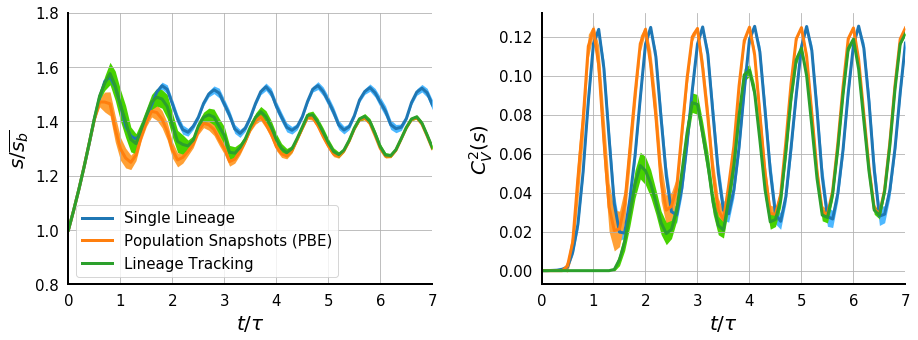

In [53]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(timearray2/doubling_time,mnszarrayMM,lw=3,label="Single Lineage")
ax[0].fill_between(np.array(timearrayMM)/doubling_time,np.array(mnszarrayMM)-np.array(errmnszMM),np.array(mnszarrayMM)+np.array(errmnszMM),
                 alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0,label='_nolegend_')
ax[0].plot(timearray2/doubling_time,mnszarray,lw=3,label='Population Snapshots (PBE)')
ax[0].fill_between(np.array(timearray1)/doubling_time,np.array(mnszarray)-np.array(errmnsz),np.array(mnszarray)+np.array(errmnsz),
                 alpha=1, edgecolor='#FFA035', facecolor='#FFA035',linewidth=0,label='_nolegend_')
    
ax[0].plot(timearray2/doubling_time,mnsz2array,lw=3,label='Lineage Tracking')
ax[0].fill_between(np.array(timearray2)/doubling_time,np.array(mnsz2array)-np.array(errmnsz2arr),np.array(mnsz2array)+np.array(errmnsz2arr),
                 alpha=1, edgecolor='#47D200', facecolor='#47D200',linewidth=0,label='_nolegend_')
ax[1].plot(timearray2/doubling_time, cvszarrayMM,lw=3)
ax[1].fill_between(np.array(timearray2)/doubling_time,np.array(cvszarrayMM)-np.array(errcv2szMM),np.array(cvszarrayMM)+np.array(errcv2szMM),
                 alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0)


ax[1].plot(timearray2/doubling_time, cvszarray,lw=3)
ax[1].fill_between(np.array(timearray2)/doubling_time,np.array(cvszarray)-np.array(errcv2sz),np.array(cvszarray)+np.array(errcv2sz),
                 alpha=1, edgecolor='#FFA035', facecolor='#FFA035',linewidth=0)

ax[1].plot(timearray2/doubling_time, cvszarray2,lw=3)
ax[1].fill_between(np.array(timearray2)/doubling_time,np.array(cvszarray2)-np.array(errcv2sz2arr),np.array(cvszarray2)+np.array(errcv2sz2arr),
                 alpha=1, edgecolor='#47D200', facecolor='#47D200',linewidth=0)

ax[0].set_ylabel("$s/\overline{s_b}$",size=20)
ax[1].set_ylabel("$C_V^2(s)$",size=20)
ax[0].set_xlabel(r"$t/\tau$",size=20)
ax[1].set_xlabel(r"$t/\tau$",size=20)
ax[0].legend(fontsize=15)
ax[0].set_ylim([0.8,1.8])
#ax[1].set_ylim([0,0.15])
for l in [0,1]:
    ax[l].set_xlim([0,7])
    taqui=np.arange(0,7.5,step=1)
    ax[l].set_xticks(np.array(taqui))
    ax[l].grid()
    ax[l].tick_params(axis='x', labelsize=15)
    ax[l].tick_params(axis='y', labelsize=15)
    for axis in ['bottom','left']:
        ax[l].spines[axis].set_linewidth(2)
        ax[l].tick_params(axis='both', width=2,length=6)
    for axis in ['top','right']:
        ax[l].spines[axis].set_linewidth(0)
        ax[l].tick_params(axis='both', width=0,length=6)
plt.subplots_adjust(hspace=0.3,wspace=0.3)
plt.savefig('./figures/size_population.eps',bbox_inches='tight')
plt.savefig('./figures/size_population.svg',bbox_inches='tight')

In [17]:
data=pd.read_csv("./data/DivEvents2.csv")

In [18]:
gr = np.log(2)/doubling_time 

In [19]:
mean_size=1.44*meanbirthsize
sampling_time = sample_time 
rprom = 10 # RNA mean concentration (RNA/um)
pprom = 1000 # prot mean concentration (RNA/um)
gammar = 5*gr # RNA Active degradation rate
kr = rprom*(gr+gammar) # RNA transcription rate
kp = pprom*gr/rprom # Protein translation rate

In [20]:
class Bacteria:
    def __init__(self, idx, V0, num_steps, gr, divpar, k,rna,prot):
        self.dp = divpar
        self.gr = gr
        self.idx = idx
        self.popidx = idx
        self.V = V0
        self.Vb = V0
        self.Vd = V0
        self.ndiv = 0
        self.rna = rna
        self.prot = prot
        self.k = k
        self.nextrb=0
        self.nextrd=0
        self.nextp=0
    def CalcTimeEvent(self,Nr,s):#estimating reaction times from propensity function  
        if Nr>0:
            self.nextrb=(1/gr)*np.log(1-(gr/(kr*s))*np.log(np.random.rand())) #time to thenext rna creation
            self.nextrd=-np.log(np.random.rand())/(gammar*Nr)
        elif Nr<=0:
            self.nextrb=(1/gr)*np.log(1-(gr/(kr*s))*np.log(np.random.rand())) #time to thenext rna creation
            self.nextrd=1000000

In [21]:
mnR=5
mnP=500
pop = []
df= data[data.BirthTime==0]
for m in range(len(df)):
    gr=df.iloc[m].GrowthRate
    sz=df.iloc[m].Sb
    dp=df.iloc[m].DivPar
    rna=mnR
    prot=mnP
    bct = Bacteria(idx=m, V0=sz, num_steps=div_steps, gr=gr, divpar=dp, k = gr,rna=rna,prot=prot)
    bct.CalcTimeEvent(rna,sz)
    pop.append(bct)
    
#-------------------------------------------------------------------------------    
    
t=0
tmax=6*doubling_time
data=data[data.BirthTime>0]
m=0
m=0
sample_time=0.1*doubling_time
tref=sample_time
GeneFile=open("./data/PopGene.csv","w")
output="Time,Sample,Cell,Nr,Np,Size\n"

nextdiv=data.iloc[m].BirthTime
popidx=data.iloc[m].Sample
idx=data.iloc[m].Cell
idx2=data.iloc[m+1].Cell
times=pd.DataFrame([[popidx,idx,nextdiv,0]],columns=['Sample','Cell','time','Type'])
for cell in pop:
    output+="0.00,"+str(cell.popidx)+","+str(cell.idx)+','+str(cell.rna)+','+str(cell.prot)+','+str(cell.V)+"\n"
    times=pd.concat([times,pd.DataFrame([[cell.popidx,cell.idx,cell.nextrb,1],\
                            [cell.popidx,cell.idx,cell.nextrd,2]],columns=['Sample','Cell','time','Type'])])
times.reset_index(drop=True)
GeneFile.write(output)

2108

In [22]:
while m<len(data)-2 and t>=0:
    #print(t)
    nextt=np.min(times.time.tolist())
    
    if tref<nextt:
        dt=tref-t
        output=''
        for cell in pop:
            cell.V=cell.V*np.exp(cell.gr*dt)
            cell.prot+=kp*cell.rna*dt
            output+=str(tref)+','+str(int(cell.popidx))+','+str(int(cell.idx))+','+str(cell.rna)+','+str(cell.prot)+','+str(cell.V)+'\n'
        GeneFile.write(output)
        t=tref
        tref+=sample_time
        print(t)
    else:
        dt=nextt-t
        for cell in pop:
            cell.V=cell.V*np.exp(cell.gr*dt)
            cell.prot+=kp*cell.rna*dt
        t=nextt
        loc=np.argmin(times.time.tolist())
        if times.iloc[loc].Type==0:                
            df=data.iloc[m]
            idx=int(data.iloc[m].Mother)
            cell=pop[idx]
            cell.V=df.Sb
            Nr=cell.rna
            Np=cell.prot
            newnr=np.random.binomial(Nr,df.Sb/df.MotherSize)
            newnp=Np*df.Sb/df.MotherSize
            cell.rna=newnr
            cell.prot=newnp
            cell.CalcTimeEvent(newnr,cell.V)
            cell.gr=df.GrowthRate
            df=data.iloc[m+1]#The sister cell
            bct = Bacteria(idx=df.Cell, V0=df.Sb, num_steps=div_steps, gr=df.GrowthRate, divpar=df.DivPar, k = df.GrowthRate,\
                       rna=Nr-newnr,prot=Np-newnp)
            bct.popidx=cell.popidx
            bct.CalcTimeEvent(bct.rna,cell.V)
            pop.append(bct)
            times=pd.concat([times,pd.DataFrame([[bct.popidx,bct.idx,bct.nextrb+t,1],\
                            [bct.popidx,bct.idx,bct.nextrd+t,2]],columns=['Sample','Cell','time','Type'])])
            times.reset_index(drop=True)
            times.iloc[0]=[data.iloc[m+2].Sample,data.iloc[m+2].Cell,data.iloc[m+2].BirthTime,0]
            m+=2
        else:
            idx=int(times.iloc[loc].Cell)
            cell=pop[idx]
            if times.iloc[loc].Type==1:
                cell.rna+=1              
            elif times.iloc[loc].Type==2:
                cell.rna-=1
            cell.CalcTimeEvent(cell.rna,cell.V)
        if len(times[times.Cell==idx])==2:
            times.loc[times.Cell==idx,'time']=[cell.nextrb+t,cell.nextrd+t]
        else:
            times.loc[times.Cell==idx,'time']=[times.iloc[0].time,cell.nextrb+t,cell.nextrd+t]


GeneFile.close()

1.8
3.6
5.4
7.2
9.0
10.8
12.600000000000001
14.400000000000002
16.200000000000003
18.000000000000004
19.800000000000004
21.600000000000005
23.400000000000006
25.200000000000006
27.000000000000007
28.800000000000008
30.60000000000001
32.400000000000006
34.2
36.0
37.8
39.599999999999994
41.39999999999999
43.19999999999999
44.999999999999986
46.79999999999998
48.59999999999998
50.39999999999998
52.199999999999974
53.99999999999997
55.79999999999997
57.599999999999966
59.39999999999996
61.19999999999996
62.99999999999996
64.79999999999995
66.59999999999995
68.39999999999995
70.19999999999995
71.99999999999994
73.79999999999994
75.59999999999994
77.39999999999993
79.19999999999993
80.99999999999993
82.79999999999993
84.59999999999992
86.39999999999992
88.19999999999992
89.99999999999991
91.79999999999991
93.59999999999991
95.3999999999999
97.1999999999999
98.9999999999999
100.7999999999999
102.5999999999999
104.39999999999989
106.19999999999989
107.99999999999989
109.79999999999988
111.5999

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


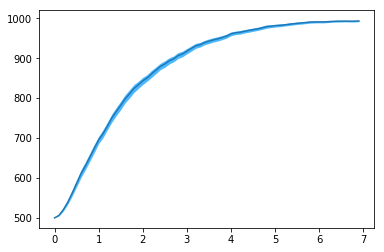

In [23]:
data1=pd.read_csv("./data/PopGene.csv")

timearray=data1.Time.unique()

mnprotarray=[]
cvprotarray=[]
errcv2prot=[]
errmnprot=[]

for t in timearray:
    df=data1[data1.Time==t]
    szs=np.array(df.Np/df.Size)
    mean_cntr, var_cntr, std_cntr = bayesest(szs,alpha=0.95)
    mnprotarray.append(bootstrap(szs)[0])
    errmnprot.append(bootstrap(szs)[1])
    cvprotarray.append(bootstrapCV2(szs)[0])
    #errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
    errcv2prot.append(bootstrapCV2(szs)[1])
plt.plot(timearray/doubling_time,mnprotarray)
plt.fill_between(np.array(timearray)/doubling_time,np.array(mnprotarray)-np.array(errmnprot),np.array(mnprotarray)+np.array(errmnprot),
                 alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0,label="SSA")

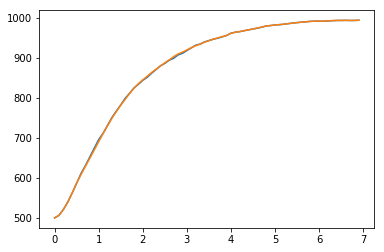

In [24]:
timearray=data1.Time.unique()

mnprotarray2=[]
cvprotarray2=[]
errcv2protarr2=[]
errmnprotarr2=[]

for t in timearray:
    df=data1[data1.Time==t]
    mntemp=[]
    meanerrmn=[]
    vartemp=[]
    meanerrvar=[]
    smparray=df.Sample.unique()
    for s in smparray:
        dft=df[df.Sample==s]
        if len(dft)>1:
            conc=np.array(dft.Np/dft.Size)
            mntemp.append(np.mean(conc))
            vartemp.append(np.var(conc)/np.mean(conc)**2)

        else:
            conc=dft.Np/dft.Size
            mntemp.append(conc.tolist()[0])
            vartemp.append(0)

            
    mnprotarray2.append(bootstrap(mntemp)[0])
    #mean_cntr, var_cntr, std_cntr = bayesest(mntemp,alpha=0.95)
    errmnprotarr2.append(bootstrap(mntemp)[1])
    cvprotarray2.append(bootstrap(vartemp)[0])
    #mean_cntr, var_cntr, std_cntr = bayesest(vartemp,alpha=0.95)
    errcv2protarr2.append(bootstrap(vartemp)[1])

plt.plot(timearray/doubling_time,mnprotarray)
#plt.fill_between(np.array(timearray)/doubling_time,np.array(mnprotarray)-np.array(errmnprot),np.array(mnprotarray)+np.array(errmnprot),
#                 alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0,label="SSA")
    
plt.plot(timearray/doubling_time,mnprotarray2)
#plt.fill_between(np.array(timearray)/doubling_time,np.array(mnprotarray2)-np.array(errmnprotarr2),np.array(mnprotarray2)+np.array(errmnprotarr2),
#                 alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0,label="SSA")

In [25]:
data=pd.read_csv("./data/DivEventsMM.csv")

In [26]:
mean_size=1.44*meanbirthsize
sampling_time = sample_time 
rprom = 10 # RNA mean concentration (RNA/um)
pprom = 1000 # prot mean concentration (RNA/um)
gammar = 5*gr # RNA Active degradation rate
kr = rprom*(gr+gammar) # RNA transcription rate
kp = pprom*gr/rprom # Protein translation rate

In [27]:
mnR=5
mnP=500
pop = []
df= data[data.BirthTime==0]
for m in range(len(df)):
    gr=df.iloc[m].GrowthRate
    sz=df.iloc[m].Sb
    dp=df.iloc[m].DivPar
    rna=mnR
    prot=mnP
    bct = Bacteria(idx=m, V0=sz, num_steps=div_steps, gr=gr, divpar=dp, k = gr,rna=rna,prot=prot)
    bct.CalcTimeEvent(rna,sz)
    pop.append(bct)
    
#-------------------------------------------------------------------------------    
    
t=0
tmax=7*doubling_time
data=data[data.BirthTime>0]
m=0
m=0
sample_time=0.1*doubling_time
tref=sample_time
GeneFile=open("./data/MMGene.csv","w")
output="Time,Sample,Cell,Nr,Np,Size\n"

nextdiv=data.iloc[m].BirthTime
popidx=data.iloc[m].Sample
idx=data.iloc[m].Cell
idx2=data.iloc[m+1].Cell
times=pd.DataFrame([[popidx,idx,nextdiv,0]],columns=['Sample','Cell','time','Type'])
for cell in pop:
    output+="0.00,"+str(cell.popidx)+","+str(cell.idx)+','+str(cell.rna)+','+str(cell.prot)+','+str(cell.V)+"\n"
    times=pd.concat([times,pd.DataFrame([[cell.popidx,cell.idx,cell.nextrb,1],\
                            [cell.popidx,cell.idx,cell.nextrd,2]],\
                                         columns=['Sample','Cell','time','Type'])])
times.reset_index(drop=True)
GeneFile.write(output)

47808

In [28]:
start=time.time()
while m<len(data)-1 and t>=0:
    #print(t)
    nextt=np.min(times.time.tolist())
    if tref<nextt:
        dt=tref-t
        output=''
        for cell in pop:
            cell.V=cell.V*np.exp(cell.gr*dt)
            cell.prot+=kp*cell.rna*dt
            output+=str(tref)+','+str(int(cell.popidx))+','+str(int(cell.idx))+','+str(cell.rna)+','+str(cell.prot)+','+str(cell.V)+'\n'
        GeneFile.write(output)
        t=tref
        tref+=sample_time
        print(t)
    else:
        dt=nextt-t
        for cell in pop:
            cell.V=cell.V*np.exp(cell.gr*dt)
            cell.prot+=kp*cell.rna*dt
        t=nextt
        loc=np.argmin(times.time.tolist())
        if times.iloc[loc].Type==0:                
            df=data.iloc[m]
            idx=int(data.iloc[m].Mother)
            cell=pop[idx]
            cell.V=df.Sb
            Nr=cell.rna
            newnr=np.random.binomial(Nr,df.Sb/df.MotherSize)
            newnp=cell.prot*df.Sb/df.MotherSize
            cell.rna=newnr
            cell.prot=newnp
            cell.CalcTimeEvent(newnr,cell.V)
            cell.gr=df.GrowthRate
            m+=1
            times.iloc[0]=[data.iloc[m].Sample,data.iloc[m].Cell,data.iloc[m].BirthTime,0]
        else:
            idx=int(times.iloc[loc].Cell)
            cell=pop[idx]
            if times.iloc[loc].Type==1:
                cell.rna+=1              
            elif times.iloc[loc].Type==2:
                cell.rna-=1
            cell.CalcTimeEvent(cell.rna,cell.V)
        if len(times[times.Cell==idx])==2:
            times.loc[times.Cell==idx,'time']=[cell.nextrb+t,cell.nextrd+t]
        else:
            times.loc[times.Cell==idx,'time']=[times.iloc[0].time,cell.nextrb+t,cell.nextrd+t]


GeneFile.close()
print('It took', np.int(time.time()-start), 'seconds.')

1.8
3.6
5.4
7.2
9.0
10.8
12.600000000000001
14.400000000000002
16.200000000000003
18.000000000000004
19.800000000000004
21.600000000000005
23.400000000000006
25.200000000000006
27.000000000000007
28.800000000000008
30.60000000000001
32.400000000000006
34.2
36.0
37.8
39.599999999999994
41.39999999999999
43.19999999999999
44.999999999999986
46.79999999999998
48.59999999999998
50.39999999999998
52.199999999999974
53.99999999999997
55.79999999999997
57.599999999999966
59.39999999999996
61.19999999999996
62.99999999999996
64.79999999999995
66.59999999999995
68.39999999999995
70.19999999999995
71.99999999999994
73.79999999999994
75.59999999999994
77.39999999999993
79.19999999999993
80.99999999999993
82.79999999999993
84.59999999999992
86.39999999999992
88.19999999999992
89.99999999999991
91.79999999999991
93.59999999999991
95.3999999999999
97.1999999999999
98.9999999999999
100.7999999999999
102.5999999999999
104.39999999999989
106.19999999999989
107.99999999999989
109.79999999999988
111.5999

In [29]:

data1=pd.read_csv("./data/MMGene.csv")

timearrayMM=data1.Time.unique()

mnprotarrayMM=[]
cvprotarrayMM=[]
errcv2protMM=[]
errmnprotMM=[]

for t in timearrayMM:
    df=data1[data1.Time==t]
    prots=np.array(df.Np/df.Size)
    mnprotarrayMM.append(np.mean(prots))
    errmnprotMM.append(bootstrap(prots)[1])
    cvprotarrayMM.append(bootstrapCV2(prots)[0])
    #errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
    errcv2protMM.append(bootstrapCV2(prots)[1])


In [30]:
ax[0].plot(timearray2/doubling_time,mnszarrayMM,lw=3,label="Single Lineage")
ax[0].fill_between(np.array(timearray2)/doubling_time,np.array(mnszarrayMM)-np.array(errmnszMM),np.array(mnszarrayMM)+np.array(errmnszMM),
                 alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0,label='_nolegend_')
ax[0].plot(timearray2/doubling_time,mnszarray,lw=3,label='Population Snapshots (PBE)')
ax[0].fill_between(np.array(timearray1)/doubling_time,np.array(mnszarray)-np.array(errmnsz),np.array(mnszarray)+np.array(errmnsz),
                 alpha=1, edgecolor='#FFA035', facecolor='#FFA035',linewidth=0,label='_nolegend_')
    
ax[0].plot(timearray2/doubling_time,mnsz2array,lw=3,label='Lineage Tracking')
ax[0].fill_between(np.array(timearray2)/doubling_time,np.array(mnsz2array)-np.array(errmnsz2arr),np.array(mnsz2array)+np.array(errmnsz2arr),
                 alpha=1, edgecolor='#47D200', facecolor='#47D200',linewidth=0,label='_nolegend_')
ax[1].plot(timearray2/doubling_time, cvszarrayMM,lw=3)
ax[1].fill_between(np.array(timearray2)/doubling_time,np.array(cvszarrayMM)-np.array(errcv2szMM),np.array(cvszarrayMM)+np.array(errcv2szMM),
                 alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0)


ax[1].plot(timearray2/doubling_time, cvszarray,lw=3)
ax[1].fill_between(np.array(timearray2)/doubling_time,np.array(cvszarray)-np.array(errcv2sz),np.array(cvszarray)+np.array(errcv2sz),
                 alpha=1, edgecolor='#FFA035', facecolor='#FFA035',linewidth=0)

ax[1].plot(timearray2/doubling_time, cvszarray2,lw=3)
ax[1].fill_between(np.array(timearray2)/doubling_time,np.array(cvszarray2)-np.array(errcv2sz2arr),np.array(cvszarray2)+np.array(errcv2sz2arr),
                 alpha=1, edgecolor='#47D200', facecolor='#47D200',linewidth=0)

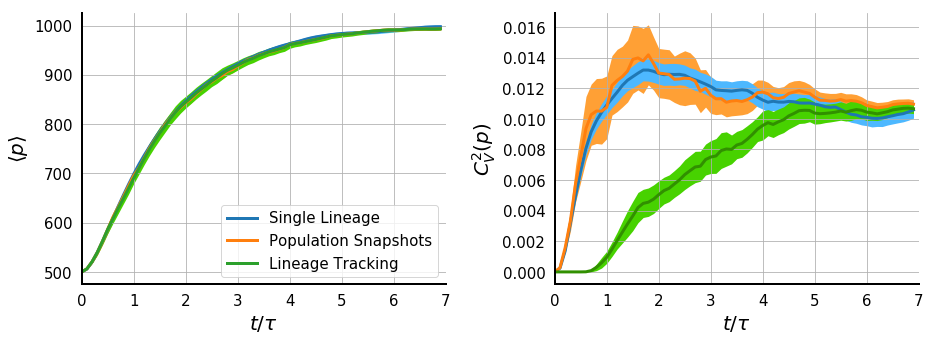

In [39]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(timearrayMM/doubling_time,mnprotarrayMM,lw=3,label="Single Lineage")
ax[0].fill_between(np.array(timearrayMM)/doubling_time,np.array(mnprotarrayMM)-np.array(errmnprotMM),np.array(mnprotarrayMM)+np.array(errmnprotMM),
               alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0,label='_nolegend_')
ax[0].plot(timearrayMM/doubling_time,mnprotarray,lw=3,label="Population Snapshots")
ax[0].fill_between(np.array(timearrayMM)/doubling_time,np.array(mnprotarray)-np.array(errmnprot),np.array(mnprotarray)+np.array(errmnprot),
                alpha=1, edgecolor='#FFA035', facecolor='#FFA035',linewidth=0,label='_nolegend_')
    
ax[0].plot(timearrayMM/doubling_time,mnprotarray2,lw=3,label="Lineage Tracking")
ax[0].fill_between(np.array(timearrayMM)/doubling_time,np.array(mnprotarray2)-np.array(errmnprotarr2),np.array(mnprotarray2)+np.array(errmnprotarr2),
                 alpha=1, edgecolor='#47D200', facecolor='#47D200',linewidth=0,label='_nolegend_')


ax[1].plot(timearrayMM/doubling_time,cvprotarrayMM,lw=3)

#ax[1].plot(timearrayMM/doubling_time,cvprotarray,lw=3)
ax[1].fill_between(np.array(timearray)/doubling_time,np.array(cvprotarray)-np.array(errcv2prot),np.array(cvprotarray)+np.array(errcv2prot),
                 alpha=1, edgecolor='#FFA035', facecolor='#FFA035',linewidth=0,label="SSA")
ax[1].plot(timearrayMM/doubling_time,cvprotarray,lw=3)

ax[1].fill_between(np.array(timearrayMM)/doubling_time,np.array(cvprotarrayMM)-np.array(errcv2protMM),np.array(cvprotarrayMM)+np.array(errcv2protMM),
                 alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0,label="SSA")
ax[1].plot(timearray/doubling_time,cvprotarray2,lw=3,c="#319000")
ax[1].fill_between(np.array(timearray)/doubling_time,np.array(cvprotarray2)-np.array(errcv2protarr2),np.array(cvprotarray2)+np.array(errcv2protarr2),
                 alpha=1,  edgecolor='#47D200', facecolor='#47D200',linewidth=0,label="SSA")
ax[0].legend(fontsize=15)

ax[0].set_ylabel(r"$\langle p\rangle$",size=20)
ax[1].set_ylabel("$C_V^2(p)$",size=20)
ax[0].set_xlabel(r"$t/\tau$",size=20)
ax[1].set_xlabel(r"$t/\tau$",size=20)
#ax[0].set_ylim([1,1.7])
#ax[1].set_ylim([0,0.15])
for l in [0,1]:
    ax[l].set_xlim([0,7])
    taqui=np.arange(0,7.5,step=1)
    ax[l].set_xticks(np.array(taqui))
    ax[l].grid()
    ax[l].tick_params(axis='x', labelsize=15)
    ax[l].tick_params(axis='y', labelsize=15)
    for axis in ['bottom','left']:
        ax[l].spines[axis].set_linewidth(2)
        ax[l].tick_params(axis='both', width=2,length=6)
    for axis in ['top','right']:
        ax[l].spines[axis].set_linewidth(0)
        ax[l].tick_params(axis='both', width=0,length=6)
plt.subplots_adjust(hspace=0.3,wspace=0.3)
plt.savefig('./figures/Gene_population.eps',bbox_inches='tight')
plt.savefig('./figures/Gene_population.svg',bbox_inches='tight')

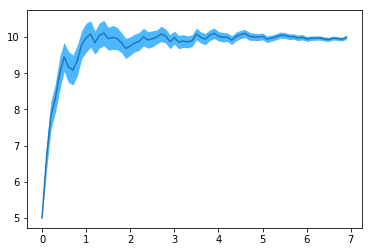

In [32]:
data1=pd.read_csv("./data/PopGene.csv")

timearray=data1.Time.unique()

mnrnaarray=[]
cvrnaarray=[]
errcv2rna=[]
errmnrna=[]

for t in timearray:
    df=data1[data1.Time==t]
    szs=np.array(df.Nr/df.Size)
    mnrnaarray.append(bootstrap(szs)[0])
    errmnrna.append(bootstrap(szs)[1])
    cvrnaarray.append(bootstrapCV2(szs)[0])
    errcv2rna.append(bootstrapCV2(szs)[1])
plt.plot(timearray/doubling_time,mnrnaarray)
plt.fill_between(np.array(timearray)/doubling_time,np.array(mnrnaarray)-np.array(errmnrna),np.array(mnrnaarray)+np.array(errmnrna),
                 alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0,label="SSA")

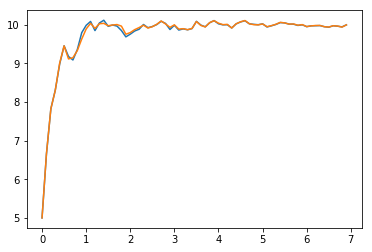

In [33]:
timearray=data1.Time.unique()

mnrnaarray2=[]
cvrnaarray2=[]
errcv2rnaarr2=[]
errmnrnaarr2=[]

for t in timearray:
    df=data1[data1.Time==t]
    mntemp=[]
    meanerrmn=[]
    vartemp=[]
    meanerrvar=[]
    smparray=df.Sample.unique()
    for s in smparray:
        dft=df[df.Sample==s]
        if len(dft)>1:
            conc=np.array(dft.Nr/dft.Size)
            mntemp.append(np.mean(conc))
            vartemp.append(np.var(conc)/np.mean(conc)**2)
        else:
            conc=dft.Nr/dft.Size
            mntemp.append(conc.tolist()[0])
            vartemp.append(0)
            
    mnrnaarray2.append(bootstrap(mntemp)[0])
    #mean_cntr, var_cntr, std_cntr = bayesest(mntemp,alpha=0.95)
    errmnrnaarr2.append(bootstrap(mntemp)[1])
    cvrnaarray2.append(bootstrap(vartemp)[0])
    #mean_cntr, var_cntr, std_cntr = bayesest(vartemp,alpha=0.95)
    errcv2rnaarr2.append(bootstrap(vartemp)[1])

plt.plot(timearray/doubling_time,mnrnaarray)
#plt.fill_between(np.array(timearray)/doubling_time,np.array(mnrnaarray)-np.array(errmnrna),np.array(mnrnaarray)+np.array(errmnrna),
#                 alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0,label="SSA")
    
plt.plot(timearray/doubling_time,mnrnaarray2)
#plt.fill_between(np.array(timearray)/doubling_time,np.array(mnrnaarray2)-np.array(errmnrnaarr2),np.array(mnrnaarray2)+np.array(errmnrnaarr2),
#                 alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0,label="SSA")

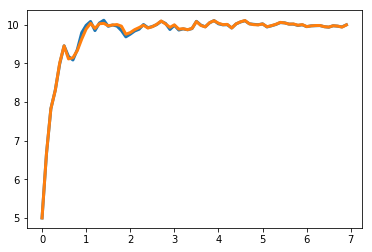

In [34]:

plt.plot(timearrayMM/doubling_time,mnrnaarray,lw=3,label="Population Snapshots")
#ax[0].fill_between(np.array(timearray1)/doubling_time,np.array(mnrnaarray)-np.array(errmnrna),np.array(mnrnaarray)+np.array(errmnrna),
 #                alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0,label="SSA")
    
plt.plot(timearrayMM/doubling_time,mnrnaarray2,lw=3,label="Mean Population")
#ax[0].fill_between(np.array(timearray1)/doubling_time,np.array(mnrnaarray2)-np.array(errmnrnaarr2),np.array(mnrnaarray2)+np.array(errmnrnaarr2),
#                 alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0,label="SSA")

In [35]:

data1=pd.read_csv("./data/MMGene.csv")

timearrayMM=data1.Time.unique()

mnrnaarrayMM=[]
cvrnaarrayMM=[]
errcv2rnaMM=[]
errmnrnaMM=[]

for t in timearrayMM:
    df=data1[data1.Time==t]
    rnas=np.array(df.Nr/df.Size)
    mean_cntr, var_cntr, std_cntr = bayesest(rnas,alpha=0.95)
    mnrnaarrayMM.append(bootstrap(rnas)[0])
    errmnrnaMM.append(bootstrap(rnas)[1])
    cvrnaarrayMM.append(bootstrapCV2(rnas)[0])
    #errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
    errcv2rnaMM.append(bootstrapCV2(rnas)[1])


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


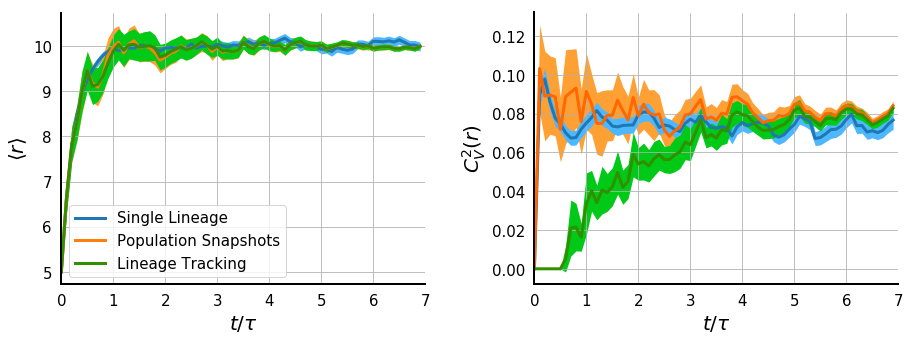

In [36]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(timearrayMM/doubling_time,mnrnaarrayMM,lw=3,label="Single Lineage")
ax[0].fill_between(np.array(timearrayMM)/doubling_time,np.array(mnrnaarrayMM)-np.array(errmnrnaMM),np.array(mnrnaarrayMM)+np.array(errmnrnaMM),
                 alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0,label='_nolegend_')
ax[0].plot(timearrayMM/doubling_time,mnrnaarray,lw=3,label="Population Snapshots")
ax[0].fill_between(np.array(timearrayMM)/doubling_time,np.array(mnrnaarray)-np.array(errmnrna),np.array(mnrnaarray)+np.array(errmnrna),
                alpha=1, edgecolor='#FFA035', facecolor='#FFA035',linewidth=0,label='_nolegend_')
    
ax[0].plot(timearrayMM/doubling_time,mnrnaarray2,lw=3,c="#319000",label="Lineage Tracking")
ax[0].fill_between(np.array(timearrayMM)/doubling_time,np.array(mnrnaarray2)-np.array(errmnrnaarr2),np.array(mnrnaarray2)+np.array(errmnrnaarr2),
                 alpha=1, edgecolor='#00C917', facecolor='#00C917',linewidth=0,label='_nolegend_')


ax[1].plot(timearrayMM/doubling_time,cvrnaarrayMM,lw=3)
ax[1].fill_between(np.array(timearray)/doubling_time,np.array(cvrnaarray)-np.array(errcv2rna),np.array(cvrnaarray)+np.array(errcv2rna),
                 alpha=1, edgecolor='#FFA035', facecolor='#FFA035',linewidth=0,label="SSA")
ax[1].plot(timearrayMM/doubling_time,cvrnaarray,lw=3,c='#FF6800')
ax[1].fill_between(np.array(timearrayMM)/doubling_time,np.array(cvrnaarrayMM)-np.array(errcv2rnaMM),np.array(cvrnaarrayMM)+np.array(errcv2rnaMM),
                 alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0,label="SSA")
ax[1].plot(timearray/doubling_time,cvrnaarray2,lw=3,c="#319000")
ax[1].fill_between(np.array(timearray)/doubling_time,np.array(cvrnaarray2)-np.array(errcv2rnaarr2),np.array(cvrnaarray2)+np.array(errcv2rnaarr2),
                 alpha=1, edgecolor='#00C917', facecolor='#00C917',linewidth=0,label="SSA")
ax[0].legend(fontsize=15)

ax[0].set_ylabel(r"$\langle r\rangle$",size=20)
ax[1].set_ylabel("$C_V^2(r)$",size=20)
ax[0].set_xlabel(r"$t/\tau$",size=20)
ax[1].set_xlabel(r"$t/\tau$",size=20)
#ax[0].set_ylim([1,1.7])
#ax[1].set_ylim([0,0.15])
for l in [0,1]:
    ax[l].set_xlim([0,7])
    taqui=np.arange(0,7.5,step=1)
    ax[l].set_xticks(np.array(taqui))
    ax[l].grid()
    ax[l].tick_params(axis='x', labelsize=15)
    ax[l].tick_params(axis='y', labelsize=15)
    for axis in ['bottom','left']:
        ax[l].spines[axis].set_linewidth(2)
        ax[l].tick_params(axis='both', width=2,length=6)
    for axis in ['top','right']:
        ax[l].spines[axis].set_linewidth(0)
        ax[l].tick_params(axis='both', width=0,length=6)
plt.subplots_adjust(hspace=0.3,wspace=0.3)
plt.savefig('./figures/RNA_population.eps',bbox_inches='tight')
plt.savefig('./figures/RNA_population.svg',bbox_inches='tight')

In [55]:
GeneFile=open("./data/GeneStatistics.csv","w")
output="Time,Type,MeanSz,ErrorMeanSz,CV2Sz,ErrorCV2Sz,MeanProt,ErrorMeanProt,CV2Prot,ErrorCV2Prot,MeanRNA,ErrorMeanRNA,CV2RNA,ErrorCV2RNA\n"
for l in range(len(timearrayMM)-1):
    output+=str(timearrayMM[l])+',Single Lineage,'+str(mnszarrayMM[l])+','+str(errmnszMM[l])+','+str(cvszarrayMM[l])\
    +','+str(errcv2szMM[l])+','+str(mnprotarrayMM[l])+','+str(errmnprotMM[l])+','+str(cvprotarrayMM[l])+','+str(errcv2protMM[l])\
    +','+str(mnrnaarrayMM[l])+','+str(errmnrnaMM[l])+','+str(cvrnaarrayMM[l])+','+str(errcv2rnaMM[l])+'\n'
for l in range(len(timearray)):
    output+=str(timearray[l])+',Population Snapshots,'+str(mnszarray[l])+','+str(errmnsz[l])+','+str(cvszarray[l])\
    +','+str(errcv2sz[l])+','+str(mnprotarray[l])+','+str(errmnprot[l])+','+str(cvprotarray[l])+','+str(errcv2prot[l])\
    +','+str(mnrnaarray[l])+','+str(errmnrna[l])+','+str(cvrnaarray[l])+','+str(errcv2rna[l])+'\n'
for l in range(len(timearray)):
    output+=str(timearray[l])+',Lineage Tracking,'+str(mnsz2array[l])+','+str(errmnsz2arr[l])+','+str(cvszarray2[l])\
    +','+str(errcv2sz2arr[l])+','+str(mnprotarray2[l])+','+str(errmnprotarr2[l])+','+str(cvprotarray2[l])+','+str(errcv2protarr2[l])\
    +','+str(mnrnaarray2[l])+','+str(errmnrnaarr2[l])+','+str(cvrnaarray2[l])+','+str(errcv2rnaarr2[l])+'\n'
GeneFile.write(output)
GeneFile.close() 